## Imports

In [48]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

In [2]:
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNeXt50_32X4D_Weights

In [3]:
from tqdm.notebook import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip -q "/content/drive/My Drive/Colab Notebooks/CSC420/SDDsubset.zip" -d Image
!unzip -q "/content/drive/My Drive/Colab Notebooks/CSC420/DBIsubset.zip" -d Image

In [7]:
SDD_dataset = ImageFolder('Image/SDDsubset')
DBI_dataset = ImageFolder('Image/DBIsubset')

## Dataset Exploration

In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
len(DBI_dataset)

646

In [10]:
len(DBI_dataset.classes)

7

In [11]:
print("Raw folder names:", DBI_dataset.classes)

Raw folder names: ['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador_retriever', 'pug', 'siberian_husky']


In [12]:
breeds = []
for n in DBI_dataset.classes:
    breeds.append(n)

print("\nFirst few breed names:", breeds[:7])


First few breed names: ['bernese_mountain_dog', 'border_collie', 'chihuahua', 'golden_retriever', 'labrador_retriever', 'pug', 'siberian_husky']


## Creating training, validation and testing dataset

In [13]:
random_seed = 45
torch.manual_seed(random_seed);

In [14]:
test_pct = 0.3
dbi_test_size = int(len(DBI_dataset)*test_pct)
dbi_dataset_size = len(DBI_dataset) - dbi_test_size

val_pct = 0.1
dbi_val_size = int(dbi_dataset_size*val_pct)
dbi_train_size = dbi_dataset_size - dbi_val_size


dbi_train_size, dbi_val_size, dbi_test_size

(408, 45, 193)

In [15]:
dbi_train_ds, dbi_val_ds, dbi_test_ds = random_split(DBI_dataset, [dbi_train_size, dbi_val_size, dbi_test_size])
len(dbi_train_ds), len(dbi_val_ds), len(dbi_test_ds)

(408, 45, 193)

golden_retriever
<class 'PIL.Image.Image'>


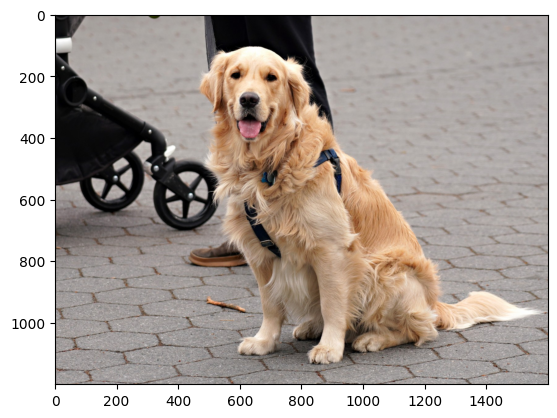

In [16]:
img, label = dbi_train_ds[6]
print(DBI_dataset.classes[label])
plt.imshow(img)
print(type(img))

In [17]:
test_pct = 0.3
sdd_test_size = int(len(SDD_dataset)*test_pct)
sdd_dataset_size = len(SDD_dataset) - sdd_test_size

val_pct = 0.1
sdd_val_size = int(sdd_dataset_size*val_pct)
sdd_train_size = sdd_dataset_size - sdd_val_size


sdd_train_size, sdd_val_size, sdd_test_size

(778, 86, 369)

In [18]:
sdd_train_ds, sdd_val_ds, sdd_test_ds = random_split(SDD_dataset, [sdd_train_size, sdd_val_size, sdd_test_size])
len(sdd_train_ds), len(sdd_val_ds), len(sdd_test_ds)

(778, 86, 369)

pug
<class 'PIL.Image.Image'>


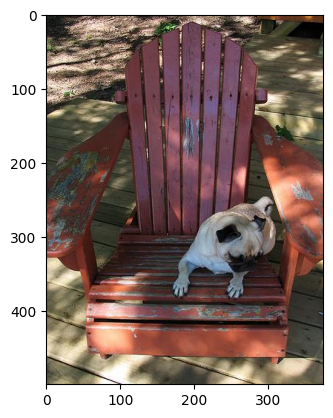

In [21]:
img, label = sdd_train_ds[6]
print(SDD_dataset.classes[label])
plt.imshow(img)
print(type(img))

## Creating Custom Dataset

To create our custom Dataset, we need to extend Pytorch's `Dataset` class.
We need to implement 3 methods inside our Custom Dataset Class:

1. `__init__`
2. `__len__`
3. `__getitem__`

In [52]:
class DogBreedDataset(Dataset):

    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)
            return img, label

Use random cropping, random horizontal flipping, and random rotations for augmentation.

In [23]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)

])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [24]:
dbi_train_dataset = DogBreedDataset(dbi_train_ds, train_transform)
dbi_val_dataset = DogBreedDataset(dbi_val_ds, val_transform)
dbi_test_dataset = DogBreedDataset(dbi_test_ds, test_transform)

In [25]:
sdd_train_dataset = DogBreedDataset(sdd_train_ds, train_transform)
sdd_val_dataset = DogBreedDataset(sdd_val_ds, val_transform)
sdd_test_dataset = DogBreedDataset(sdd_test_ds, test_transform)

Lets quickly take a look into our training dataset

3


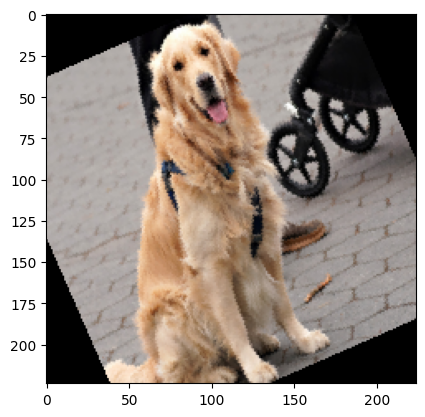

In [26]:
img, label = dbi_train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

Now we will create Training , validation data and test data loader

In [27]:
#use a smaller batch size for resnext 32
#batch_size =64
batch_size = 16

# Create DataLoaders
dbi_train_dl = DataLoader(dbi_train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
dbi_val_dl = DataLoader(dbi_val_dataset, batch_size*2, num_workers=2, pin_memory=True)
dbi_test_dl = DataLoader(dbi_test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [28]:
#use a smaller batch size for resnext 32
#batch_size =64
batch_size =16

# Create DataLoaders
sdd_train_dl = DataLoader(sdd_train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
sdd_val_dl = DataLoader(sdd_val_dataset, batch_size*2, num_workers=2, pin_memory=True)
sdd_test_dl = DataLoader(sdd_test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [41]:
sdd_dataset = DogBreedDataset(SDD_dataset, test_transform)
sdd_dataloader = DataLoader(sdd_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

We can also take a peek into our dataset by creating grid of images using Pytorch's `make_grid()` method.

In [29]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

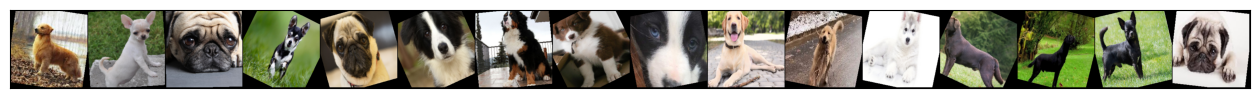

In [30]:
show_batch(dbi_train_dl)

## Moving Data to GPU

In [31]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [32]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

## Task II - simple CNN Training on the DBI

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [34]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss

    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}

    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))


In [35]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self, num_classes=120, use_dropout=True):
        super().__init__()
        self.use_dropout = use_dropout

        # First conv block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Second conv block
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Calculate size after convolutions
        self.dropout1 = nn.Dropout(0.5) if use_dropout else nn.Identity()
        self.fc1 = nn.Linear(8 * 56 * 56, 32)  # Adjust size based on input dimensions
        self.dropout2 = nn.Dropout(0.5) if use_dropout else nn.Identity()
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)

        # Calculate accuracy
        _, predicted = torch.max(out.data, 1)
        acc = (predicted == labels).float().mean()

        return {'loss': loss, 'acc': acc}

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)

        # Calculate accuracy
        _, predicted = torch.max(out.data, 1)
        acc = (predicted == labels).float().mean()

        return {'val_loss': loss, 'val_acc': acc}

    def epoch_end(self, epoch, result):
      print(f"Epoch [{epoch}]")
      print(f"train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, test_loss: {result['test_loss']:.4f}")
      print(f"train_acc: {result['train_acc']:.4f}, val_acc: {result['val_acc']:.4f}, test_acc: {result['test_acc']:.4f}")


In [36]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):

        # Training phase
        model.train()
        train_losses = []
        train_accs = []
        lrs = []
        for batch in tqdm(train_loader):
            training_result = model.training_step(batch)

            loss = training_result['loss']
            acc = training_result['acc']

            # calculates gradients
            loss.backward()

            # check gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            # perform gradient descent and modifies the weights
            optimizer.step()

            # reset the gradients
            optimizer.zero_grad()

            train_losses.append(loss.detach())
            #train_accs.append(acc)
            train_accs.append(acc if isinstance(acc, torch.Tensor) else torch.tensor(acc, device=loss.device))

            # record and update lr
            lrs.append(torch.tensor(get_lr(optimizer)))

            # modifies the lr value
            sched.step()

        result = {
            'train_loss': torch.stack(train_losses).mean().item(),
            'train_acc': torch.stack(train_accs).mean().item(),
            'lrs': [lr.item() for lr in lrs]
        }

        # Validation phase
        val_result = evaluate(model, val_loader)
        result.update(val_result)
        '''val_result = evaluate(model, val_loader)
        result.update({
            'val_loss': val_result['val_loss'],
            'val_acc': val_result['val_acc']
        })'''

        # Test phase (using same evaluation method as validation)
        test_result = evaluate(model, test_loader, prefix='test')
        result.update(test_result)
        '''test_result = evaluate(model, test_loader)
        result.update({
            'test_loss': test_result['val_loss'],
            'test_acc': test_result['val_acc']
        })'''

        model.epoch_end(epoch, result)
        history.append(result)


    return history



@torch.no_grad()
def evaluate(model, data_loader, prefix='val'):

    model.eval()
    outputs = [model.validation_step(batch) for batch in data_loader]
    batch_losses = [x['val_loss'] for x in outputs]
    batch_acc = [x['val_acc'] for x in outputs]

    batch_acc = [torch.tensor(x, device='cuda' if torch.cuda.is_available() else 'cpu') if isinstance(x, float) else x for x in batch_acc]

    return {
        f'{prefix}_loss': torch.stack(batch_losses).mean().item(),
        f'{prefix}_acc': torch.stack(batch_acc).mean().item()
    }

In [ ]:
def plot_accuracies(history_with_dropout, history_without_dropout):
    plt.figure(figsize=(10, 6))
    epochs = range(len(history_with_dropout))

    # Plot with dropout results
    plt.plot(epochs, [x['train_acc'] for x in history_with_dropout], 'b-',
             label='Training (with dropout)')
    plt.plot(epochs, [x['val_acc'] for x in history_with_dropout], 'g-',
             label='Validation (with dropout)')
    plt.plot(epochs, [x['test_acc'] for x in history_with_dropout], 'r-',
             label='Test (with dropout)')

    # Plot without dropout results
    plt.plot(epochs, [x['train_acc'] for x in history_without_dropout], 'b--',
             label='Training (without dropout)')
    plt.plot(epochs, [x['val_acc'] for x in history_without_dropout], 'g--',
             label='Validation (without dropout)')
    plt.plot(epochs, [x['test_acc'] for x in history_without_dropout], 'r--',
             label='Test (without dropout)')

    plt.title('Training Validation and Test Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
model_with_dropout = DogBreedClassificationCNN(use_dropout=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_with_dropout = model_with_dropout.to(device)
#epochs, max_lr, model, train_loader, val_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam
history_with_dropout = fit_one_cycle(
    epochs=10,
    max_lr=0.001,
    model=model_with_dropout,
    train_loader=dbi_train_dl,
    val_loader=dbi_val_dl,
    test_loader=dbi_test_dl,
    weight_decay=1e-4,
    grad_clip=None,
    opt_func=torch.optim.Adam
)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0]
train_loss: 4.5412, val_loss: 4.5711, test_loss: 4.5788
train_acc: 0.0156, val_acc: 0.0000, test_acc: 0.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1]
train_loss: 4.2322, val_loss: 4.3336, test_loss: 4.3352
train_acc: 0.0558, val_acc: 0.0000, test_acc: 0.0000


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2]
train_loss: 3.9125, val_loss: 3.8669, test_loss: 3.9129
train_acc: 0.1124, val_acc: 0.2000, test_acc: 0.1782


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3]
train_loss: 3.5479, val_loss: 3.3800, test_loss: 3.3839
train_acc: 0.1265, val_acc: 0.1111, test_acc: 0.1822


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4]
train_loss: 3.1482, val_loss: 2.9147, test_loss: 2.9525
train_acc: 0.2135, val_acc: 0.2000, test_acc: 0.2714


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5]
train_loss: 2.8319, val_loss: 2.4851, test_loss: 2.5920
train_acc: 0.2262, val_acc: 0.2889, test_acc: 0.2712


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6]
train_loss: 2.8175, val_loss: 2.4029, test_loss: 2.4991
train_acc: 0.2262, val_acc: 0.2444, test_acc: 0.2908


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7]
train_loss: 2.7242, val_loss: 2.1451, test_loss: 2.2087
train_acc: 0.2463, val_acc: 0.2889, test_acc: 0.3181


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8]
train_loss: 2.6224, val_loss: 2.0792, test_loss: 2.1279
train_acc: 0.2619, val_acc: 0.3111, test_acc: 0.3453


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9]
train_loss: 2.7394, val_loss: 2.0569, test_loss: 2.1037
train_acc: 0.2560, val_acc: 0.3111, test_acc: 0.3453


In [ ]:
model_without_dropout = DogBreedClassificationCNN(use_dropout=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_without_dropout = model_without_dropout.to(device)
#epochs, max_lr, model, train_loader, val_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam
history_without_dropout = fit_one_cycle(
    epochs=10,
    max_lr=0.001,
    model=model_without_dropout,
    train_loader=dbi_train_dl,
    val_loader=dbi_val_dl,
    test_loader=dbi_test_dl,
    weight_decay=1e-4,
    grad_clip=None,
    opt_func=torch.optim.Adam
)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0]
train_loss: 4.4482, val_loss: 4.6267, test_loss: 4.6148
train_acc: 0.0997, val_acc: 0.0889, test_acc: 0.1010


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1]
train_loss: 3.2524, val_loss: 3.9659, test_loss: 3.9909
train_acc: 0.2366, val_acc: 0.0889, test_acc: 0.1165


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2]
train_loss: 2.2903, val_loss: 2.9720, test_loss: 2.9431
train_acc: 0.2872, val_acc: 0.1111, test_acc: 0.1359


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3]
train_loss: 1.7785, val_loss: 2.3852, test_loss: 2.3502
train_acc: 0.3534, val_acc: 0.2444, test_acc: 0.2598


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4]
train_loss: 1.5601, val_loss: 1.9664, test_loss: 1.9937
train_acc: 0.4249, val_acc: 0.3333, test_acc: 0.2365


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5]
train_loss: 1.5278, val_loss: 1.9061, test_loss: 1.9476
train_acc: 0.4241, val_acc: 0.2889, test_acc: 0.2710


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6]
train_loss: 1.5597, val_loss: 1.8457, test_loss: 1.8422
train_acc: 0.4271, val_acc: 0.2889, test_acc: 0.3684


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7]
train_loss: 1.4816, val_loss: 1.7711, test_loss: 1.7512
train_acc: 0.4665, val_acc: 0.2889, test_acc: 0.3527


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8]
train_loss: 1.3361, val_loss: 1.7113, test_loss: 1.7225
train_acc: 0.5357, val_acc: 0.3111, test_acc: 0.3604


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9]
train_loss: 1.3292, val_loss: 1.6928, test_loss: 1.7095
train_acc: 0.5305, val_acc: 0.3778, test_acc: 0.3835


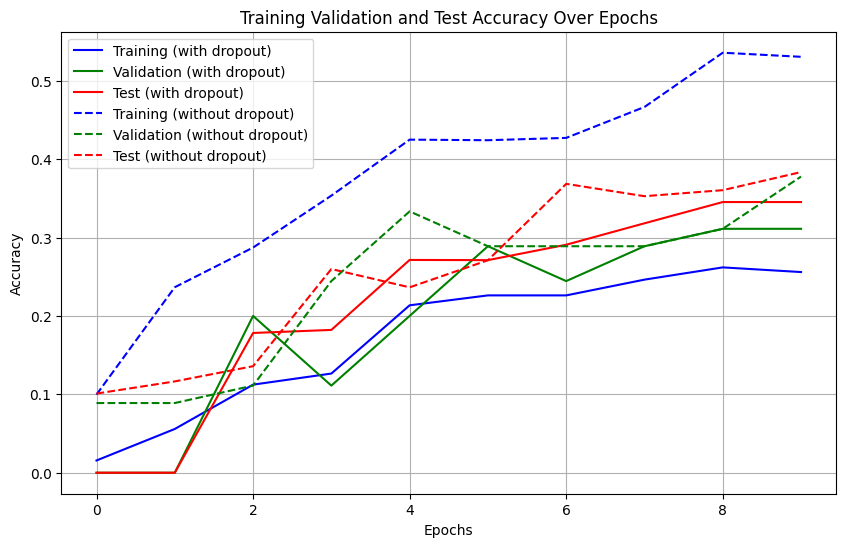

In [ ]:
plot_accuracies(history_with_dropout, history_without_dropout)

## Task III - ResNet Training on the DBI

In [ ]:
class DogBreedResnet18(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet18(weights=None)

        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)

        # Calculate accuracy
        _, predicted = torch.max(out.data, 1)
        acc = (predicted == labels).float().mean()

        acc = torch.tensor(acc, device=loss.device)

        return {'loss': loss, 'acc': acc}

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)

        # Calculate accuracy
        _, predicted = torch.max(out.data, 1)
        acc = (predicted == labels).float().mean()
        acc = torch.tensor(acc, device=loss.device)

        return {'val_loss': loss, 'val_acc': acc}

    def epoch_end(self, epoch, result):
      print(f"Epoch [{epoch}]")
      print(f"train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, test_loss: {result['test_loss']:.4f}")
      print(f"train_acc: {result['train_acc']:.4f}, val_acc: {result['val_acc']:.4f}, test_acc: {result['test_acc']:.4f}")


In [71]:
def plot_history_accuracy(history, title):
    plt.figure(figsize=(10, 6))
    epochs = range(len(history))

    # Plot with dropout results
    plt.plot(epochs, [x['train_acc'] for x in history], 'b-',
             label='Training')
    plt.plot(epochs, [x['val_acc'] for x in history], 'g-',
             label='Validation')
    plt.plot(epochs, [x['test_acc'] for x in history], 'r-',
             label='Test')

    plt.title(f'{title} - Training Validation and Test Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Initialize model
num_classes = len(breeds)
model_resnet18 = DogBreedResnet18(num_classes).to(device)

# Train model
history_resnet18 = fit_one_cycle(
    epochs=10,
    max_lr=0.001,
    model=model_resnet18,
    train_loader=dbi_train_dl,
    val_loader=dbi_val_dl,
    test_loader=dbi_test_dl,
    weight_decay=1e-4,
    grad_clip=None,
    opt_func=torch.optim.Adam
)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0]
train_loss: 1.9941, val_loss: 1.9597, test_loss: 1.9799
train_acc: 0.2054, val_acc: 0.1778, test_acc: 0.1820


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1]
train_loss: 1.7063, val_loss: 6.9213, test_loss: 6.5550
train_acc: 0.3318, val_acc: 0.1778, test_acc: 0.1936


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2]
train_loss: 1.8326, val_loss: 4.9617, test_loss: 5.3066
train_acc: 0.3036, val_acc: 0.1556, test_acc: 0.1356


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3]
train_loss: 1.6901, val_loss: 7.6428, test_loss: 5.8556
train_acc: 0.3341, val_acc: 0.1111, test_acc: 0.1090


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4]
train_loss: 1.4497, val_loss: 3.5013, test_loss: 3.0224
train_acc: 0.4323, val_acc: 0.1333, test_acc: 0.1592


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5]
train_loss: 1.2731, val_loss: 3.2308, test_loss: 2.6754
train_acc: 0.5052, val_acc: 0.2222, test_acc: 0.2633


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6]
train_loss: 1.2989, val_loss: 2.3316, test_loss: 2.1637
train_acc: 0.5491, val_acc: 0.1778, test_acc: 0.2599


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7]
train_loss: 1.1857, val_loss: 1.9127, test_loss: 1.7486
train_acc: 0.5670, val_acc: 0.2889, test_acc: 0.3258


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8]
train_loss: 1.0357, val_loss: 1.6839, test_loss: 1.5704
train_acc: 0.6094, val_acc: 0.2444, test_acc: 0.4070


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9]
train_loss: 1.0672, val_loss: 1.4944, test_loss: 1.4514
train_acc: 0.5945, val_acc: 0.4444, test_acc: 0.4498


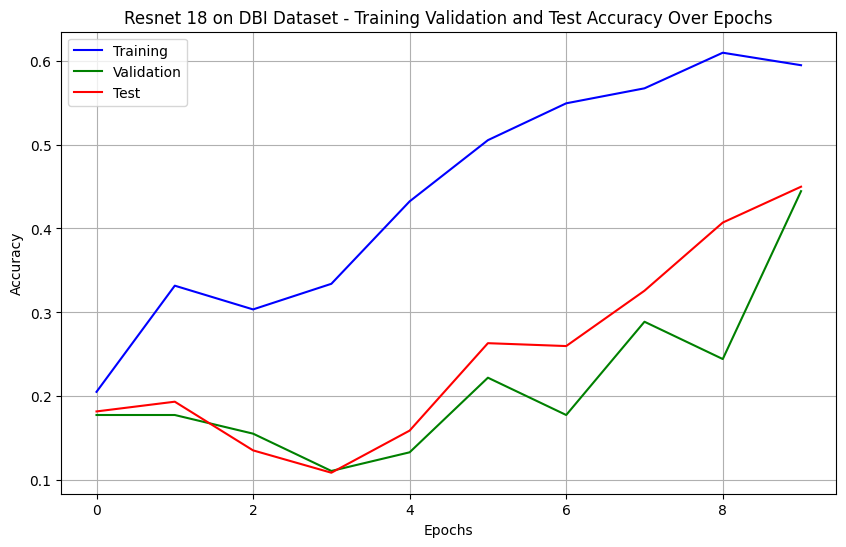

In [ ]:
plot_history_accuracy(history_resnet18, "Resnet 18 on DBI Dataset")

In [42]:
def evaluate_model_on_entire_SDD(model, dataloader, criterion=nn.CrossEntropyLoss(), device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    avg_loss = total_loss / len(dataloader)

    print("Evaluation Results on Entire Dataset:")
    print(f"Accuracy: {accuracy:.2f}% | Loss: {avg_loss:.4f}")
    print('-' * 80)

    return {'accuracy': accuracy, 'loss': avg_loss}

In [ ]:
def evaluate_model_on_SDD(model, train_loader, val_loader, test_loader, criterion=nn.CrossEntropyLoss()):
    model.eval()
    results = {
        'train_acc': 0, 'val_acc': 0, 'test_acc': 0,
        'train_loss': 0, 'val_loss': 0, 'test_loss': 0
    }

    #evaluate on a single dataloader
    def evaluate_loader(loader):
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        accuracy = 100. * correct / total
        avg_loss = total_loss / len(loader)
        return accuracy, avg_loss

    train_acc, train_loss = evaluate_loader(train_loader)
    results['train_acc'] = train_acc
    results['train_loss'] = train_loss

    val_acc, val_loss = evaluate_loader(val_loader)
    results['val_acc'] = val_acc
    results['val_loss'] = val_loss

    test_acc, test_loss = evaluate_loader(test_loader)
    results['test_acc'] = test_acc
    results['test_loss'] = test_loss

    print("Evaluation Results:")
    print(f"Train Acc: {train_acc:.2f}% | Train Loss: {train_loss:.4f}")
    print(f"Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.4f}")
    print(f"Test Acc: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")
    print('-' * 80)

    return results

In [ ]:
new_results = evaluate_model_on_SDD(model_resnet18, sdd_train_dl, sdd_val_dl, sdd_test_dl)

Evaluation Results:
Train Acc: 18.89% | Train Loss: 2.6464
Val Acc: 20.93% | Val Loss: 2.5594
Test Acc: 20.05% | Test Loss: 2.5071
--------------------------------------------------------------------------------


## TASK IV

In [37]:
class DogBreedPretrainedModel(ImageClassificationBase):
    def __init__(self, pytorch_model, num_classes):
        super().__init__()
        self.network = pytorch_model

        # Replace last layer
        num_ftrs = self.network.fc.in_features

        self.network.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)

        # Calculate accuracy
        _, predicted = torch.max(out.data, 1)
        acc = (predicted == labels).float().mean()

        acc = acc.clone().detach()

        return {'loss': loss, 'acc': acc}

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)

        # Calculate accuracy
        _, predicted = torch.max(out.data, 1)
        acc = (predicted == labels).float().mean()
        acc = acc.clone().detach()

        return {'val_loss': loss, 'val_acc': acc}

    def epoch_end(self, epoch, result):
      print(f"Epoch [{epoch}]")
      print(f"train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, test_loss: {result['test_loss']:.4f}")
      print(f"train_acc: {result['train_acc']:.4f}, val_acc: {result['val_acc']:.4f}, test_acc: {result['test_acc']:.4f}")


In [38]:
dbi_model_resnet18_pretrain = DogBreedPretrainedModel(models.resnet18(weights=ResNet18_Weights.DEFAULT), len(breeds))
dbi_model_resnet18_pretrain = dbi_model_resnet18_pretrain.to(device)

sdd_model_resnet18_pretrain = DogBreedPretrainedModel(models.resnet18(weights=ResNet18_Weights.DEFAULT), len(breeds))
sdd_model_resnet18_pretrain = sdd_model_resnet18_pretrain.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


In [ ]:
dbi_history_resnet18_pretrain = fit_one_cycle(
    epochs=10,
    max_lr=0.001,
    model=dbi_model_resnet18_pretrain,
    train_loader=dbi_train_dl,
    val_loader=dbi_val_dl,
    test_loader=dbi_test_dl,
    weight_decay=1e-4,
    grad_clip=None,
    opt_func=torch.optim.Adam
)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0]
train_loss: 1.6943, val_loss: 1.0413, test_loss: 1.0434
train_acc: 0.3929, val_acc: 0.7333, test_acc: 0.7518


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1]
train_loss: 0.3704, val_loss: 0.1910, test_loss: 0.2755
train_acc: 0.9301, val_acc: 0.9556, test_acc: 0.8760


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2]
train_loss: 0.1383, val_loss: 1.1743, test_loss: 1.2082
train_acc: 0.9576, val_acc: 0.7556, test_acc: 0.7322


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3]
train_loss: 0.1302, val_loss: 1.4358, test_loss: 1.8644
train_acc: 0.9516, val_acc: 0.7111, test_acc: 0.5814


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4]
train_loss: 0.2430, val_loss: 0.6403, test_loss: 0.9474
train_acc: 0.9174, val_acc: 0.8000, test_acc: 0.7359


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5]
train_loss: 0.1961, val_loss: 2.1492, test_loss: 2.6863
train_acc: 0.9159, val_acc: 0.5778, test_acc: 0.4645


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6]
train_loss: 0.1132, val_loss: 0.9531, test_loss: 1.0741
train_acc: 0.9531, val_acc: 0.7333, test_acc: 0.7054


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7]
train_loss: 0.0650, val_loss: 0.7352, test_loss: 0.6504
train_acc: 0.9821, val_acc: 0.8667, test_acc: 0.8023


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8]
train_loss: 0.0658, val_loss: 0.5703, test_loss: 0.4168
train_acc: 0.9844, val_acc: 0.8444, test_acc: 0.8874


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9]
train_loss: 0.0514, val_loss: 0.4838, test_loss: 0.3181
train_acc: 0.9866, val_acc: 0.8444, test_acc: 0.8990


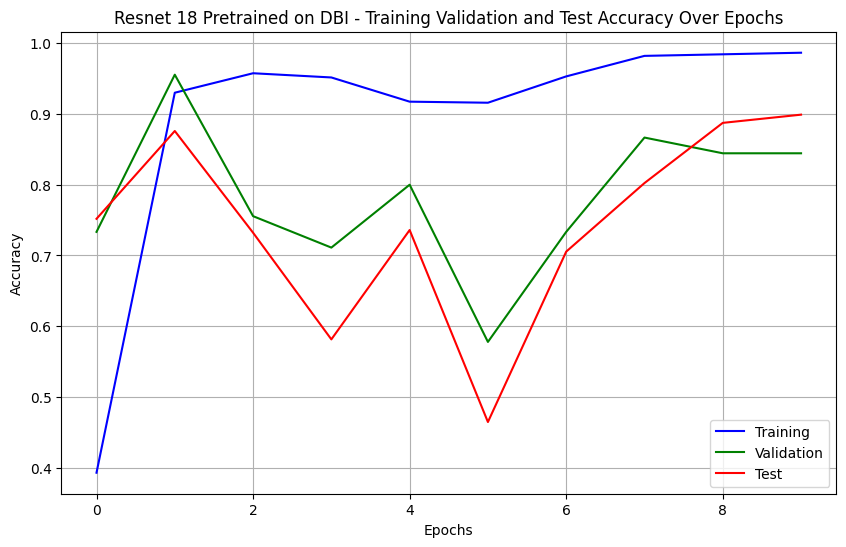

In [ ]:
plot_history_accuracy(dbi_history_resnet18_pretrain, "Resnet 18 Pretrained on DBI")

In [ ]:
evaluate_model_on_entire_SDD(dbi_model_resnet18_pretrain, sdd_dataloader)

Evaluation Results on Entire Dataset:
Accuracy: 35.04% | Loss: 4.3859

{'accuracy': 35.03649635036496, 'loss': 4.38592883348465}

This output got accidentially deleted.

In [72]:
evaluate_model_on_SDD(dbi_model_resnet18_pretrain,
                      sdd_train_dl, sdd_val_dl,
                      sdd_test_dl, criterion= nn.CrossEntropyLoss())

NameError: name 'evaluate_model_on_SDD' is not defined

In [ ]:
dbi_model_resnet34_pretrain = DogBreedPretrainedModel(models.resnet34(weights=ResNet34_Weights.DEFAULT), len(breeds))
dbi_model_resnet34_pretrain = dbi_model_resnet34_pretrain.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 91.5MB/s]


In [ ]:
dbi_history_resnet34_pretrain = fit_one_cycle(
    epochs=10,
    max_lr=0.001,
    model=dbi_model_resnet34_pretrain,
    train_loader=dbi_train_dl,
    val_loader=dbi_val_dl,
    test_loader=dbi_test_dl,
    weight_decay=1e-4,
    grad_clip=None,
    opt_func=torch.optim.Adam
)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [0]
train_loss: 1.4994, val_loss: 0.4017, test_loss: 0.3845
train_acc: 0.4531, val_acc: 0.9556, test_acc: 0.9650


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1]
train_loss: 0.2221, val_loss: 0.3724, test_loss: 0.3215
train_acc: 0.9546, val_acc: 0.9333, test_acc: 0.9148


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2]
train_loss: 0.2905, val_loss: 2.9960, test_loss: 4.0375
train_acc: 0.8884, val_acc: 0.6000, test_acc: 0.6127


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3]
train_loss: 0.4816, val_loss: 5.2611, test_loss: 5.0315
train_acc: 0.8385, val_acc: 0.4667, test_acc: 0.4886


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4]
train_loss: 0.3789, val_loss: 5.8286, test_loss: 6.5312
train_acc: 0.8780, val_acc: 0.4000, test_acc: 0.3720


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5]
train_loss: 0.2597, val_loss: 1.9423, test_loss: 1.8721
train_acc: 0.9241, val_acc: 0.6667, test_acc: 0.6165


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6]
train_loss: 0.1183, val_loss: 0.5232, test_loss: 0.8704
train_acc: 0.9754, val_acc: 0.8444, test_acc: 0.7712


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7]
train_loss: 0.0820, val_loss: 0.2633, test_loss: 0.5159
train_acc: 0.9762, val_acc: 0.8889, test_acc: 0.8568


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8]
train_loss: 0.0871, val_loss: 0.1851, test_loss: 0.3971
train_acc: 0.9740, val_acc: 0.9333, test_acc: 0.8607


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9]
train_loss: 0.0488, val_loss: 0.1799, test_loss: 0.3682
train_acc: 0.9911, val_acc: 0.9111, test_acc: 0.8955


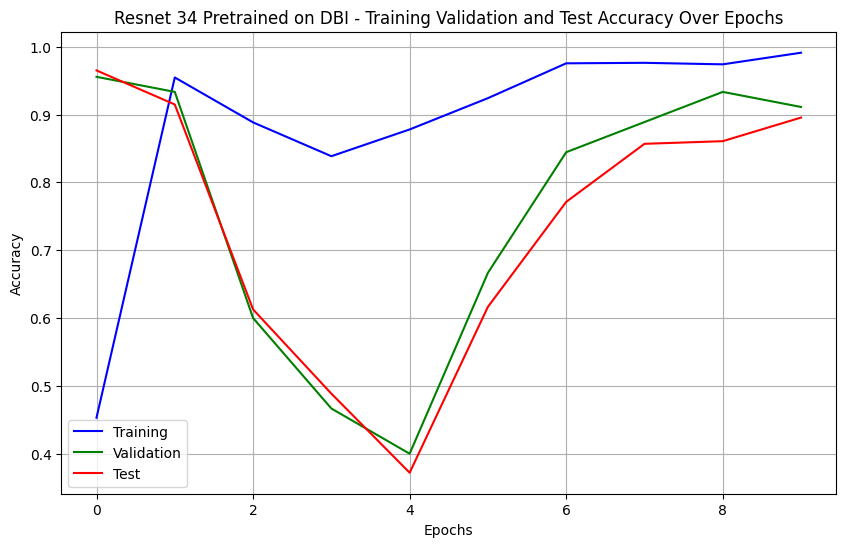

In [ ]:
plot_history_accuracy(dbi_history_resnet34_pretrain, "Resnet 34 Pretrained on DBI")

In [ ]:
evaluate_model_on_entire_SDD(dbi_model_resnet34_pretrain, sdd_dataloader)

Evaluation Results on Entire Dataset:
Accuracy: 31.31% | Loss: 4.1968

{'accuracy': 31.305758313057584, 'loss': 4.19683871269226}


This output got accidentially deleted.

In [ ]:
evaluate_model_on_SDD(dbi_model_resnet34_pretrain,
                      sdd_train_dl, sdd_val_dl,
                      sdd_test_dl, criterion= nn.CrossEntropyLoss())

Evaluation Results:
Train Acc: 34.83% | Train Loss: 3.8317
Val Acc: 33.72% | Val Loss: 4.2961
Test Acc: 30.89% | Test Loss: 4.6970
--------------------------------------------------------------------------------


{'train_acc': 34.832904884318765,
 'val_acc': 33.72093023255814,
 'test_acc': 30.89430894308943,
 'train_loss': 3.8316663045149584,
 'val_loss': 4.296111583709717,
 'test_loss': 4.696986834208171}

In [39]:
dbi_model_resnext32_pretrain = DogBreedPretrainedModel(models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT), len(breeds))
dbi_model_resnext32_pretrain = dbi_model_resnext32_pretrain.to(device)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 119MB/s]


In [40]:
dbi_history_resnext32_pretrain = fit_one_cycle(
    epochs=10,
    max_lr=0.001,
    model=dbi_model_resnext32_pretrain,
    train_loader=dbi_train_dl,
    val_loader=dbi_val_dl,
    test_loader=dbi_test_dl,
    weight_decay=1e-4,
    grad_clip=0.1,
    opt_func=torch.optim.Adam
)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0]
train_loss: 1.5680, val_loss: 0.5757, test_loss: 0.6252
train_acc: 0.5817, val_acc: 1.0000, test_acc: 0.9688


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1]
train_loss: 0.3020, val_loss: 0.5736, test_loss: 1.3303
train_acc: 0.9231, val_acc: 0.8221, test_acc: 0.6696


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2]
train_loss: 0.5834, val_loss: 2.7216, test_loss: 2.2530
train_acc: 0.8197, val_acc: 0.4579, test_acc: 0.5804


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3]
train_loss: 0.6840, val_loss: 1.9224, test_loss: 1.4880
train_acc: 0.7812, val_acc: 0.6514, test_acc: 0.6741


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4]
train_loss: 0.5690, val_loss: 0.4232, test_loss: 0.4557
train_acc: 0.8438, val_acc: 0.8762, test_acc: 0.8661


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5]
train_loss: 0.3464, val_loss: 0.4831, test_loss: 0.4869
train_acc: 0.8822, val_acc: 0.8834, test_acc: 0.8571


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [6]
train_loss: 0.2060, val_loss: 0.2186, test_loss: 0.2039
train_acc: 0.9375, val_acc: 0.9303, test_acc: 0.9330


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [7]
train_loss: 0.1039, val_loss: 0.1525, test_loss: 0.2309
train_acc: 0.9760, val_acc: 0.9688, test_acc: 0.9330


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [8]
train_loss: 0.0686, val_loss: 0.1640, test_loss: 0.2417
train_acc: 0.9784, val_acc: 0.9531, test_acc: 0.9375


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [9]
train_loss: 0.0653, val_loss: 0.1865, test_loss: 0.2343
train_acc: 0.9832, val_acc: 0.9531, test_acc: 0.9375


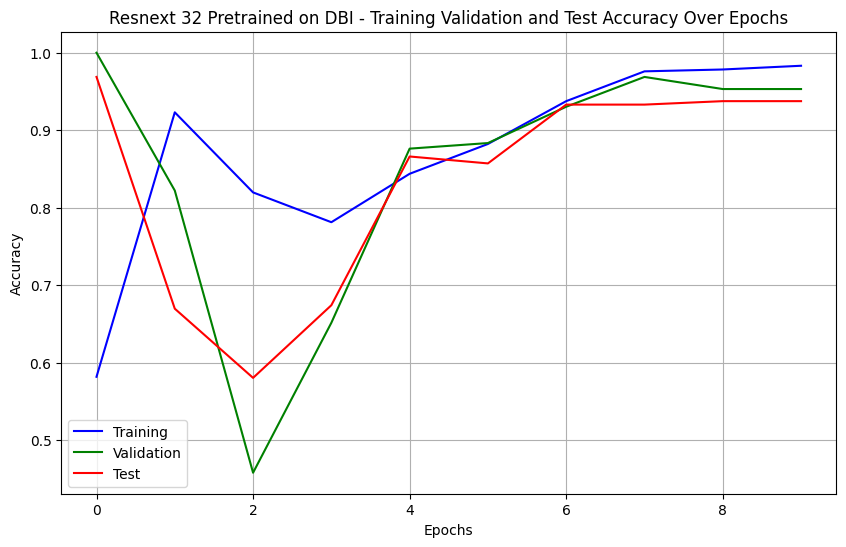

In [45]:
plot_history_accuracy(dbi_history_resnext32_pretrain, "Resnext 32 Pretrained on DBI")

In [46]:
evaluate_model_on_entire_SDD(dbi_model_resnext32_pretrain, sdd_dataloader)

Evaluation Results on Entire Dataset:
Accuracy: 36.50% | Loss: 3.8245
--------------------------------------------------------------------------------


{'accuracy': 36.496350364963504, 'loss': 3.8244626402854918}

## TASK V

In [47]:
SDD_imagefolder = ImageFolder(root='Image/SDDsubset', target_transform=lambda x: 0)
DBI_imagefolder = ImageFolder(root='Image/DBIsubset', target_transform=lambda x: 1)

In [50]:
datasets_combined = ConcatDataset([SDD_imagefolder, DBI_imagefolder])

In [51]:
test_pct = 0.3
combined_test_size = int(len(datasets_combined)*test_pct)
datasets_combined_size = len(datasets_combined) - combined_test_size

val_pct = 0.1
combined_val_size = int(datasets_combined_size*val_pct)
combined_train_size = datasets_combined_size - combined_val_size


combined_train_size, combined_val_size, combined_test_size

(1185, 131, 563)

In [53]:
combined_train_size, combined_val_ds, combined_test_ds = random_split(datasets_combined, [combined_train_size, combined_val_size, combined_test_size])

combined_train_dataset = DogBreedDataset(combined_train_size, train_transform)
combined_val_dataset = DogBreedDataset(combined_val_ds, val_transform)
combined_test_dataset = DogBreedDataset(combined_test_ds, test_transform)

In [62]:
batch_size = 64
combined_train_dl = DataLoader(combined_train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
combined_val_dl = DataLoader(combined_val_dataset, batch_size*2, num_workers=2, pin_memory=True)
combined_test_dl = DataLoader(combined_test_dataset, batch_size*2, num_workers=2, pin_memory=True)


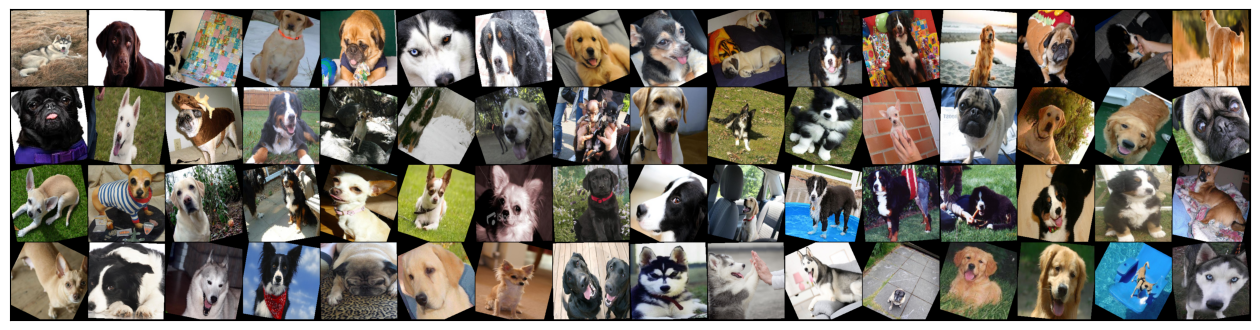

In [57]:
show_batch(combined_train_dl)

In [64]:
combined_model_resnet34_pretrain = DogBreedPretrainedModel(models.resnet34(weights=ResNet34_Weights.DEFAULT), len(breeds))
combined_model_resnet34_pretrain = combined_model_resnet34_pretrain.to(device)

In [65]:
combined_history_resnet34_pretrain = fit_one_cycle(
    epochs=10,
    max_lr=0.001,
    model=combined_model_resnet34_pretrain,
    train_loader=combined_train_dl,
    val_loader=combined_val_dl,
    test_loader=combined_test_dl,
    weight_decay=1e-4,
    grad_clip=0.1,
    opt_func=torch.optim.Adam
)

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [0]
train_loss: 1.5443, val_loss: 0.5552, test_loss: 0.5720
train_acc: 0.5052, val_acc: 0.7708, test_acc: 0.8296


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [1]
train_loss: 0.4832, val_loss: 1.6498, test_loss: 4.0425
train_acc: 0.8236, val_acc: 0.7539, test_acc: 0.4706


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [2]
train_loss: 0.3682, val_loss: 1.5926, test_loss: 2.2266
train_acc: 0.8373, val_acc: 0.6107, test_acc: 0.5652


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [3]
train_loss: 0.3403, val_loss: 0.7376, test_loss: 1.4433
train_acc: 0.8481, val_acc: 0.7656, test_acc: 0.5160


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [4]
train_loss: 0.3089, val_loss: 0.3892, test_loss: 0.5724
train_acc: 0.8603, val_acc: 0.8906, test_acc: 0.7693


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [5]
train_loss: 0.2087, val_loss: 0.3732, test_loss: 0.4922
train_acc: 0.9179, val_acc: 0.8984, test_acc: 0.8022


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [6]
train_loss: 0.1795, val_loss: 0.2392, test_loss: 0.4252
train_acc: 0.9319, val_acc: 0.9219, test_acc: 0.8280


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [7]
train_loss: 0.1068, val_loss: 0.3051, test_loss: 0.4382
train_acc: 0.9589, val_acc: 0.9141, test_acc: 0.8428


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [8]
train_loss: 0.0737, val_loss: 0.2940, test_loss: 0.4112
train_acc: 0.9746, val_acc: 0.9180, test_acc: 0.8608


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch [9]
train_loss: 0.0617, val_loss: 0.2911, test_loss: 0.4041
train_acc: 0.9762, val_acc: 0.9258, test_acc: 0.8616


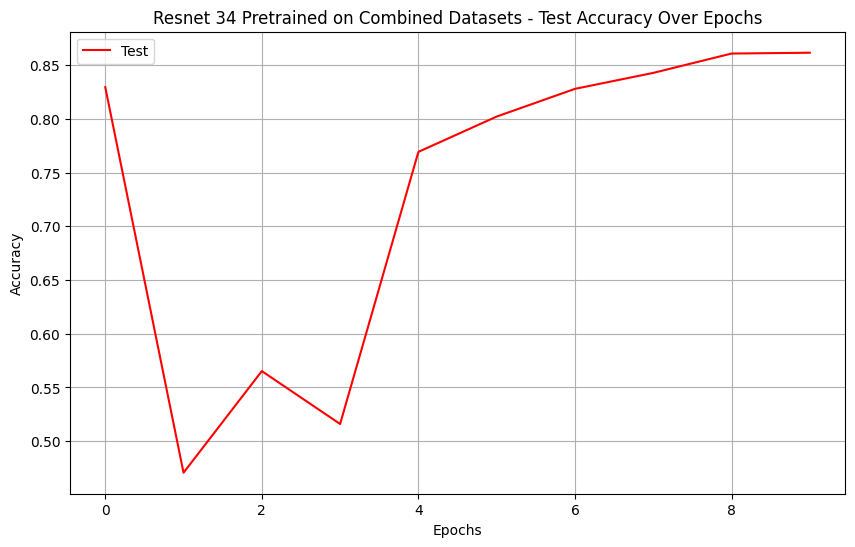

In [70]:
plot_history_accuracy(combined_history_resnet34_pretrain, "Resnet 34 Pretrained on Combined Datasets")